In [1]:
import numpy as np
from numpy import linalg as la
import networkx as nx
import matplotlib.pyplot as plt
import time
import dgl
import torch
from torch import nn
from torch.nn import functional as F

import src.dag_utils as dag_utils
from src.arch import DAGConv
from src.models import Model
from src.baselines_archs import GCNN_2L

SEED = 10
np.random.seed(SEED)
torch.manual_seed(SEED)
dgl.random.seed(SEED)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


DAG created
Inverted: 0.012512445449829102
Dq obtained: 0.16361069679260254
GSO computed: 0.015542984008789062


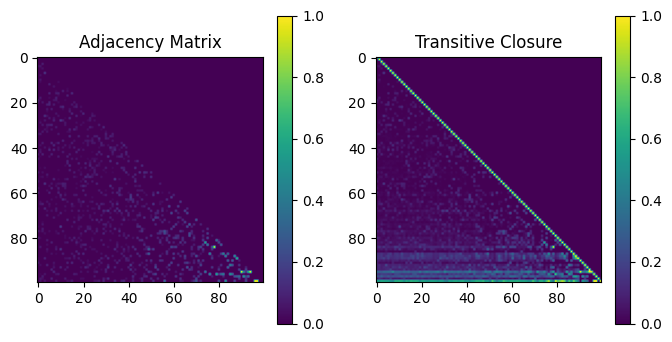

In [2]:
# Create graph
p = .2
N = 100

Adj, dag = dag_utils.create_dag(N, p)
assert nx.is_directed_acyclic_graph(dag), "Graph is not a DAG"

print("DAG created")

t_i = time.time()
W = la.inv(np.eye(N) - Adj)
W_inf = la.inv(W)
print('Inverted:', time.time()-t_i)

Dq_list = []
t_i = time.time()
Dq_list = [dag_utils.compute_Dq(dag, i, N) for i in range(N)]
print('Dq obtained:', time.time()-t_i)

t_i = time.time()
GSOs = np.array([(W * Dq_list[i]) @ W_inf for i in range(N)])
print('GSO computed:', time.time()-t_i)

# Plot graph
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
im1 = axs[0].imshow(Adj, cmap='viridis')
axs[0].set_title('Adjacency Matrix')
im2 = axs[1].imshow(W, cmap='viridis')
axs[1].set_title('Transitive Closure')
fig.colorbar(im1, ax=axs[0])
fig.colorbar(im2, ax=axs[1])


# Example 1: modeling diffusion

In [3]:
def inspect_data(X_data, Y_data):
    print('Summary for X_data:')
    for key, value in X_data.items():
        norm = la.norm(value, 2, axis=1).mean()
        print(f'\t{key}: size: {value.shape}  -  norm: {norm:.3f}')

    print('Summary for Y_data:')
    for key, value in Y_data.items():
        norm = la.norm(value, 2, axis=1).mean()
        print(f'\t{key}: size: {value.shape}  -  norm: {norm:.3f}')

In [4]:
# Create DATA
M = 5000
M_train = int(.7*M)
M_val = int(.2*M)
M_test = int(.1*M)
max_src_node = 5 #10
n_sources = 3
n_p = .05
max_GSO = 100
min_GSO = 50
n_GSOs = 25

range_GSO = np.arange(min_GSO, max_GSO)
gsos_idx = np.random.choice(range_GSO, size=n_GSOs, replace=False)
sel_GSOs = GSOs[gsos_idx]
Y, X = dag_utils.create_diff_data(M, sel_GSOs, max_src_node, n_p, n_sources,
                                  norm_y='l2_norm', norm_f_coefs=False, ftype='uniform')


X_t = torch.Tensor(X)
Y_t = torch.Tensor(Y)

X_data = {'train': X_t[:M_train], 'val': X_t[M_train:-M_test], 'test': X_t[-M_test:]}
Y_data = {'train': Y_t[:M_train], 'val': Y_t[M_train:-M_test], 'test': Y_t[-M_test:]}


Summary for X_data:
	train: size: torch.Size([3500, 100, 1])  -  norm: 0.898
	val: size: torch.Size([1000, 100, 1])  -  norm: 0.893
	test: size: torch.Size([500, 100, 1])  -  norm: 0.884
Summary for Y_data:
	train: size: torch.Size([3500, 100, 1])  -  norm: 1.004
	val: size: torch.Size([1000, 100, 1])  -  norm: 1.004
	test: size: torch.Size([500, 100, 1])  -  norm: 1.004


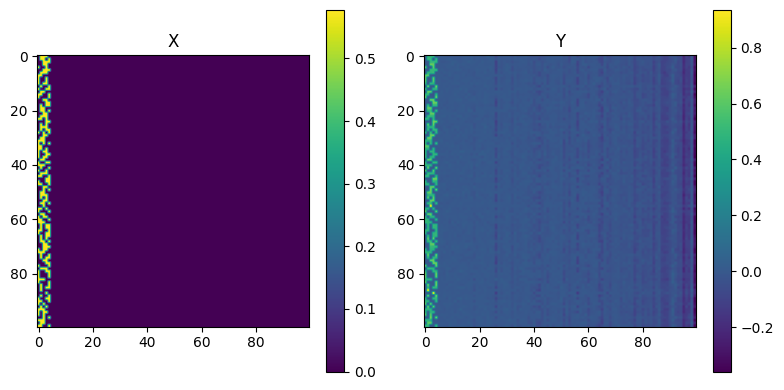

In [5]:
inspect_data(X_data, Y_data)

# Plot some data
fig, axes = plt.subplots(1, 2, figsize=(8,4))
img1  = axes[0].imshow(X[:N], cmap='viridis')
axes[0].set_title('X')
cbar1 = fig.colorbar(img1, ax=axes[0])
img2 = axes[1].imshow(Y[:N], cmap='viridis')
axes[1].set_title('Y')
cbar2 = fig.colorbar(img2, ax=axes[1])
plt.tight_layout()

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Create DAGConv model
in_dim = X.shape[2]
hid_dim = 32*4
out_dim = Y.shape[2]
L = 2
l_act = None #nn.Sigmoid()
loss = nn.MSELoss(reduction='mean')

X_train = torch.Tensor(X_data['train']).to(device)

# Training params
eval_freq = 1
batch_size = 50
lr = 1e-3 #1e-3
epochs = 35
patience = 5
wd = 1e-4
bias = True

errs = {}
results = {}
GSOs_tensor = torch.Tensor(GSOs)

print('DAGCNN')
arch = DAGConv(in_dim, hid_dim, out_dim, L, GSOs_tensor, last_act=l_act).to(device)
model = Model(arch, loss, device=device)
t_i = time.time()
losses_dag = model.fit(X_data, Y_data, lr, epochs, batch_size, wd, eval_freq=eval_freq,
                       patience=patience, verb=True)
t_e = time.time() - t_i
print('\tTime:', t_e)
errs['DAG'] = model.test(X_data['test'], Y_data['test'])
results['DAG'] = losses_dag

print('DAGCNN WITH SELECTED GSOs')
sel_GSOs = GSOs_tensor[gsos_idx]
arch = DAGConv(in_dim, hid_dim, out_dim, L, sel_GSOs, last_act=l_act, bias=bias).to(device)
model = Model(arch, loss, device=device)
t_i = time.time()
losses_dag_prior = model.fit(X_data, Y_data, lr, epochs, batch_size, wd, eval_freq=eval_freq,
                             patience=patience, verb=True)
t_e = time.time() - t_i
print('\tTime:', t_e)
errs['DAG-Prior'] = model.test(X_data['test'], Y_data['test'])
results['DAG-Prior'] = losses_dag_prior

device = 'cpu'

print('CLASSICAL GNN using A')
S = dgl.from_networkx(nx.from_numpy_array(Adj)).add_self_loop().to(device)
arch = GCNN_2L(in_dim, hid_dim, out_dim, S)
model = Model(arch, loss, device=device)
t_i = time.time()
losses_gnnA = model.fit(X_data, Y_data, lr, epochs, batch_size, wd, eval_freq=1,
                        patience=patience, verb=True)
t_e = time.time() - t_i
print('\tTime:', t_e)
errs['GNN-A'] = model.test(X_data['test'], Y_data['test'])
results['GNN-A'] = losses_gnnA

print('CLASSICAL GNN using W')
S = dgl.from_networkx(nx.from_numpy_array(W)).add_self_loop().to(device)
arch = GCNN_2L(in_dim, hid_dim, out_dim, S)
model = Model(arch, loss, device=device)
t_i = time.time()
losses_gnnW = model.fit(X_data, Y_data, lr, epochs, batch_size, wd, eval_freq=1,
                        patience=patience, verb=True)
t_e = time.time() - t_i
print('\tTime:', t_e)
errs['GNN-W'] = model.test(X_data['test'], Y_data['test'])
results['GNN-W'] = losses_gnnW

DAGCNN
Epoch 1/35 - Loss Train: 3.798895 - Val Loss: 4.096973
Epoch 2/35 - Loss Train: 0.061746 - Val Loss: 0.069783
Epoch 3/35 - Loss Train: 0.023363 - Val Loss: 0.026263
Epoch 4/35 - Loss Train: 0.006184 - Val Loss: 0.006901
Epoch 5/35 - Loss Train: 0.003652 - Val Loss: 0.003989
Epoch 6/35 - Loss Train: 0.002704 - Val Loss: 0.002768
Epoch 7/35 - Loss Train: 0.002196 - Val Loss: 0.002243
Epoch 8/35 - Loss Train: 0.001836 - Val Loss: 0.001960
Epoch 9/35 - Loss Train: 0.001716 - Val Loss: 0.001775
Epoch 10/35 - Loss Train: 0.001470 - Val Loss: 0.001578
Epoch 11/35 - Loss Train: 0.001399 - Val Loss: 0.001471
Epoch 12/35 - Loss Train: 0.001329 - Val Loss: 0.001482
Epoch 13/35 - Loss Train: 0.001295 - Val Loss: 0.001269
Epoch 14/35 - Loss Train: 0.001204 - Val Loss: 0.001220
Epoch 15/35 - Loss Train: 0.001964 - Val Loss: 0.001382
Epoch 16/35 - Loss Train: 0.001117 - Val Loss: 0.001142
Epoch 17/35 - Loss Train: 0.001096 - Val Loss: 0.001103
Epoch 18/35 - Loss Train: 0.001056 - Val Loss: 0.0

Naive error: 0.26683119841992325
- DAG: Mean err: 0.074 Std: 0.041
- DAG-Prior: Mean err: 0.075 Std: 0.032
- GNN-A: Mean err: 0.724 Std: 0.109
- GNN-W: Mean err: 0.984 Std: 0.007


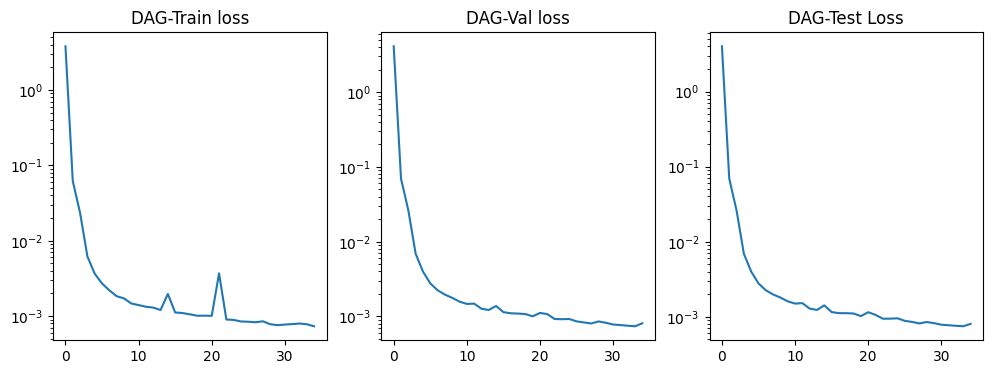

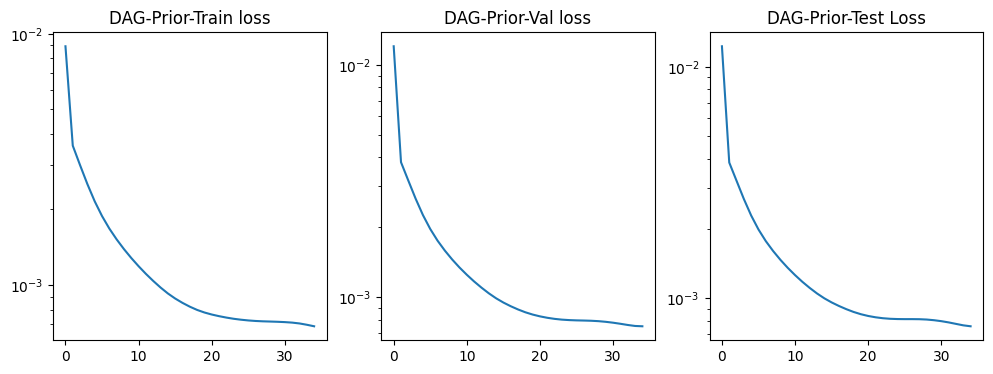

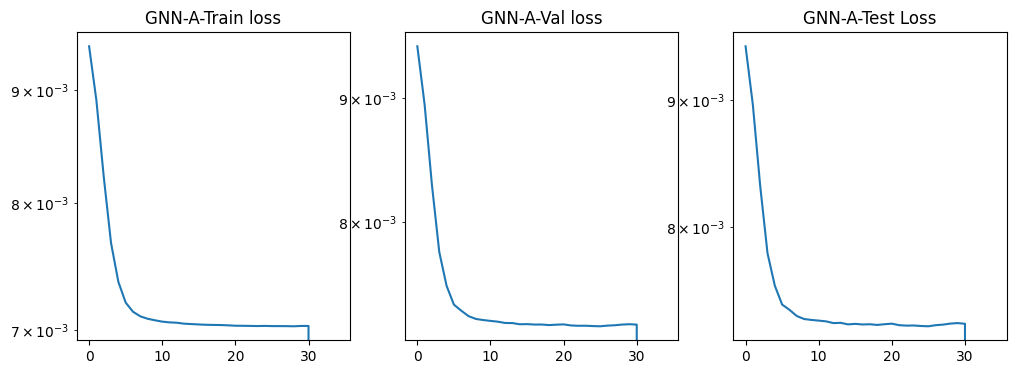

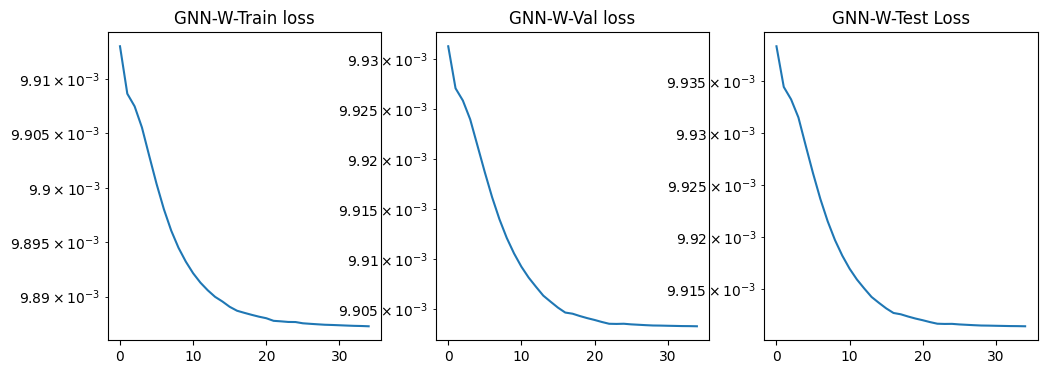

In [7]:
naive_err = (la.norm(Y-X, 2, axis=1, keepdims=True)/la.norm(Y, 2, axis=1, keepdims=True))**2
naive_err = naive_err.mean()

print('Naive error:', naive_err)
for key, value in errs.items():
    print(f'- {key}: Mean err: {value[0]:.3f} Std: {value[1]:.3f}')

for key, value in results.items():
    plt.figure(figsize=(12, 4))
    plt.subplot(1,3,1)
    plt.semilogy(value['train'])
    plt.title(f'{key}-Train loss')
    plt.subplot(1,3,2)
    plt.semilogy(value['val'])
    plt.title(f'{key}-Val loss')
    plt.subplot(1,3,3)
    plt.semilogy(value['test'])
    plt.title(f'{key}-Test Loss')


# Example 2: source identification